In [4]:
# Parameters
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

def annihilation(d):
    return np.diag(np.sqrt(np.arange(1, d)), 1)

def creation(d):
    return annihilation(d).T

def calculate_zz(eigenvalues):
    e00 = eigenvalues[0]
    e01 = eigenvalues[1]
    e10 = eigenvalues[d2]
    e11 = eigenvalues[d2+1]
    return (e00 - e01 - e10 + e11)/2/np.pi
def sort_eigenpairs(eigenvalues, eigenvectors):
    n = eigenvectors.shape[0]
    sorted_indices = []

    for i in range(n):
        max_abs_vals = np.abs(eigenvectors[i, :])
        max_index = np.argmax(max_abs_vals)
        while max_index in sorted_indices:
            max_abs_vals[max_index] = -np.inf
            max_index = np.argmax(max_abs_vals)
        sorted_indices.append(max_index)

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    return sorted_eigenvalues, sorted_eigenvectors
def state_index(index,dim):
    m,n,k = index
    M,N,K = dim
    return m*(N*K)+n*K+k
def floquetapp(A,omegad,omega3):
    dim = [5,5,5]
    d1 = d2 = d3 = 5
    omega1 = 5 * 2 * np.pi
    omega2 = 5.09* 2 * np.pi
    delta1 = delta2 = -0.24 * 2 * np.pi
    delta3 = -0.14 * 2 * np.pi
    g13 = g23 = 0.11 * 2 * np.pi
    g12 = -6e-3 * 2 * np.pi

    # Create operators
    a1, a2, a3 = [annihilation(d) for d in (d1, d2, d3)]
    a1d, a2d, a3d = [creation(d) for d in (d1, d2, d3)]
    I1, I2, I3 = [np.eye(d) for d in (d1, d2, d3)]

    # Construct Hamiltonians
    H1 = omega1 * a1d @ a1 + delta1/2 * a1d @ a1d @ a1 @ a1
    H2 = omega2 * a2d @ a2 + delta2/2 * a2d @ a2d @ a2 @ a2
    H3 = omega3 * a3d @ a3 + delta3/2 * a3d @ a3d @ a3 @ a3

    H1 = np.kron(I3, np.kron(I2, H1))
    H2 = np.kron(I3, np.kron(H2, I1))
    H3 = np.kron(H3, np.kron(I2, I1))

    # Interaction terms
    Hint12 = g12 * np.kron(I3, np.kron(a2d + a2, a1d + a1))
    Hint23 = g23 * np.kron(a3d + a3, np.kron(a2d + a2, I1))
    Hint13 = g13 * np.kron(a3d + a3, np.kron(I2, a1d + a1))

    # Total Hamiltonian
    H = H1 + H2 + H3 + Hint12 + Hint23 + Hint13
    
    Hc = np.kron(a3d + a3, np.kron(I2, I1))

    # Diagonalize
    eigenvalues, _ = eigh(H)
    eigenvalues -= eigenvalues[0]
    eigenvalues,_ = sort_eigenpairs(eigenvalues,_) 
    dim = [5,5,5]
    index001 = state_index([0,0,1],dim)
    index010 = state_index([0,1,0],dim)
    index011 = state_index([0,1,1],dim)
    index100 = state_index([1,0,0],dim)
    index101 = state_index([1,0,1],dim)
    index110 = state_index([1,1,0],dim)

    
    chi12 = eigenvalues[index011]-eigenvalues[index010]-eigenvalues[index001]
    chi23 = eigenvalues[index110]-eigenvalues[index010]-eigenvalues[index100]
    chi13 = eigenvalues[index101]-eigenvalues[index001]-eigenvalues[index100]

    omega1 = eigenvalues[index001]
    omega2 = eigenvalues[index010]
    omega3 = eigenvalues[index100]
    
    H1 = omega1 * a1d @ a1 + delta1/2 * a1d @ a1d @ a1 @ a1
    H2 = omega2 * a2d @ a2 + delta2/2 * a2d @ a2d @ a2 @ a2
    H3 = (omega3-omegad) * a3d @ a3 + delta3/2 * a3d @ a3d @ a3 @ a3
    H1 = np.kron(I3, np.kron(I2, H1))
    H2 = np.kron(I3, np.kron(H2, I1))
    H3 = np.kron(H3, np.kron(I2, I1))
    
    Hint12 = chi12 * np.kron(I3, np.kron(a2d @ a2, a1d @ a1))
    Hint23 = chi23 * np.kron(a3d @ a3, np.kron(a2d @ a2, I1))
    Hint13 = chi13 * np.kron(a3d @ a3, np.kron(I2, a1d @ a1))
    H = H1 + H2 + H3 + Hint12 + Hint23 + Hint13 + A/2*Hc
    eigenvalues, _ = eigh(H)
    eigenvalues,_ = sort_eigenpairs(eigenvalues,_) 
    eigenvalues -= eigenvalues[0]
    
    E1 = eigenvalues[index001]/2/np.pi
    E2 = eigenvalues[index010]/2/np.pi
    E3 = eigenvalues[index011]/2/np.pi
    return E1,E2,E3-E2-E1
 

In [5]:

def calculate_derivatives(A, omegad, omega3):
    energy001, energy010,zz = floquetapp(A, omegad, omega3)
    epsilon = 1e-6
    omega3p = omega3 + epsilon
    energy001_, energy010_, _ = floquetapp(A, omegad, omega3p)
    der1 = (energy001_ - energy001) / epsilon
    der2 = (energy010_ - energy010) / epsilon
    return der1, der2, omegad / (2 * np.pi)




In [7]:
from scipy.optimize import minimize

def optimize_omegad(omega3):
    # Define the objective function to minimize
    def objective(omegad):
        return np.abs(calculate_derivatives(A, omegad, omega3)[0])

    # Initial guess for omegad
    initial_guess = 3.4602 * 2 * np.pi

    # Perform the optimization
    result = minimize(objective, initial_guess, method='Nelder-Mead')

    # Optimized value of omegad
    optimized_omegad = result.x[0]
    return optimized_omegad

# Example usage
A = 0.001*2*np.pi
omega3 = 5*2*np.pi
optimized_omegad = optimize_omegad(omega3)
print("Optimized omegad:", optimized_omegad / (2 * np.pi))

Optimized omegad: 4.856434205932618


In [14]:
from joblib import Parallel, delayed


A = 0.002*2*np.pi
omega3_range = np.linspace(3.1 * 2*np.pi, 5 * 2 * np.pi, 50)
floquetapp(A,optimized_omegad,omega3)[2]
results = []
for omega3 in omega3_range:
    omegad = optimize_omegad(omega3)
    result = floquetapp(A, omegad, omega3)[2]
    results.append(result)
results = np.array(results)
A = 0.00*2*np.pi
omega3_range = np.linspace(3.1 * 2*np.pi, 5 * 2 * np.pi, 50)
floquetapp(A,optimized_omegad,omega3)[2]
results1 = []
for omega3 in omega3_range:
    omegad = optimize_omegad(omega3)
    result = floquetapp(A, omegad, omega3)[2]
    results1.append(result)
results1 = np.array(results1)

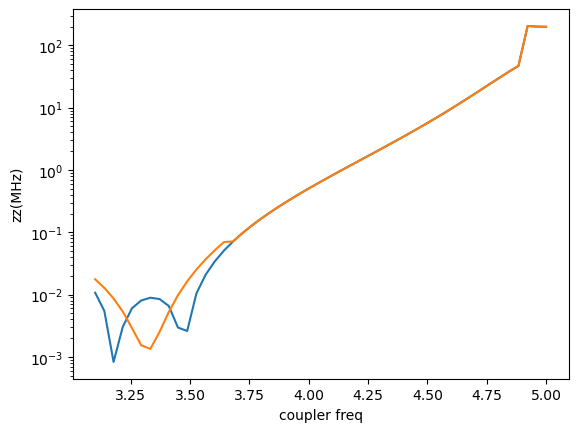

In [15]:
plt.plot(omega3_range / (2 * np.pi), np.abs(results1)*1e3)
plt.plot(omega3_range / (2 * np.pi), np.abs(results)*1e3)
plt.xlabel('coupler freq')
plt.ylabel('zz(MHz)')
plt.yscale('log')

In [ ]:
# same chi?
# optimize A and drive frequency let them overlap
# how turn on and off effect cz gate fidelity
# decoherence estimate